## Calibration of model parameters (BLACK and SCHOLES, MERTON)
The **Implied Volatility** is that value $\\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
$$ BS(S, K, T, r, \sigma) = P  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.


In [13]:
from functions.MERTONpricer import Merton_pricer
from functions.BSpricer import BS_pricer
from functions.KOUpricer import Kou_pricer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo


Let's retrieve the historic prices for european call and put options starting from 2016-01-20 and expiring 1 year later.

In [46]:
df_call = pd.read_csv('data/options_spx_call_2016.csv')
df_put = pd.read_csv('data/options_spx_put_2016.csv')

df_call['C_Midpoint'] = abs(df_call['C_BID'] + df_call['C_ASK']) / 2
df_put['P_Midpoint'] = abs(df_put['P_BID'] + df_put['P_ASK']) / 2
df_call['C_Spread'] = df_call['C_BID'] - df_call['C_ASK']
df_put['P_Spread'] = df_put['P_BID'] - df_put['P_ASK']

q = 0       # dividend yield
r = 0.1     # risk-free interest rate
sigma = 0.25 #volatility (variance of diffusion process)
S0 = df_call.iloc[0]['UNDERLYING_LAST']
T = 1
strikes = np.arange(50,151,5)
call_strikes = df_call['STRIKE']    # array of K
put_strikes = df_put['STRIKE']
exercise = 'european'

call_prices = df_call['C_Midpoint']
put_prices = df_put['P_Midpoint']

Let's initialize an object of class BS_pricer which is able to find the theoretical price of the options, given the parameters.

In [47]:
BS = BS_pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=0.1, q = q, sigma=0.12, lambd=0.5, meanJ=-0.1, stdJ=0.2, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.12, lambd=0.5, p=0.6, eta1=10, eta2=5, exercise=exercise)

call_th_prices = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])

for i, K in enumerate(call_strikes):
    bs = BS.closed_formula_call(K)
    mert = Merton.closed_formula_call(K)
    kou = Kou.closed_formula_call(K)
    call_th_prices.loc[i] = [bs, mert, kou]

print(f'Theoretical call options prices:')
print(call_th_prices)


Theoretical call options prices:
    BlackScholes       Merton          Kou
0    1067.982086  1067.936279  1068.327645
1    1045.452745  1045.366094  1045.805414
2    1022.951764  1022.807223  1023.296526
3    1000.485622  1000.261714  1000.802346
4     978.061702   977.731909   978.324334
..           ...          ...          ...
70     69.500491    12.296700    13.490937
71     62.631528    10.190773    11.506695
72     56.398177     8.491126     9.867686
73     50.748642     7.111389     8.504359
74     45.634218     5.983941     7.362402

[75 rows x 3 columns]
Theoretical call options prices:
    BlackScholes       Merton          Kou
0    1067.771853  1067.936279  1068.327645
1    1045.164821  1045.366094  1045.805414
2    1022.564270  1022.807223  1023.296526
3     999.972589  1000.261714  1000.802346
4     977.392812   977.731909   978.324334
..           ...          ...          ...
70     42.360153    12.296700    13.490937
71     36.969859    10.190773    11.506695
72     3

PUT PRICES:

In [48]:
put_th_prices = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    put_th_prices.loc[i] = [bs, mert, kou]

print(f'Theoretical put options prices:')
print(put_th_prices)

Theoretical put options prices:
    BlackScholes      Merton         Kou
0       0.024594    0.189020    0.580385
1       0.038498    0.239770    0.679090
2       0.058882    0.301835    0.791138
3       0.088137    0.377262    0.917893
4       0.129294    0.468392    1.060816
..           ...         ...         ...
70    580.699311  550.635858  551.830095
71    620.550888  593.771802  595.087724
72    661.040579  637.314025  638.690586
73    702.101761  681.176159  682.569129
74    743.673097  725.290583  726.669043

[75 rows x 3 columns]


In [49]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method, disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method == 'brent':
        x, res = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if res.converged:
            return x

    if method =='fsolve':
        #X0 = [0.03, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 2]   # set of
        X0 = [0.1, 0.5, 1, 3]
        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.5
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result


    if disp:
        return -1

Let's now compute the implied volatilities from the true market prices *call_prices*.

In [50]:
IV_BS = []; IV_M = []; IV_K = []

for i in range(len(call_prices)):
    IV_BS.append(implied_volatility(call_th_prices['BlackScholes'].values[i], S=S0, strike=call_strikes[i], t=T, rate=r,q=q, type_o='call', method='newton') )
    IV_M.append(implied_volatility(call_th_prices['Merton'].values[i], S=S0, strike = call_strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_K.append(implied_volatility(call_th_prices['Kou'].values[i], S=S0, strike = call_strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))

imp_vol_call = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])
imp_vol_call['BlackScholes'] = IV_BS
imp_vol_call['Merton'] = IV_M
imp_vol_call['Kou'] = IV_K

print(f'Implied volatilities found by each model for call options:\n{imp_vol_call}')

Implied volatilities found by each model for call options:
    BlackScholes    Merton       Kou
0           0.25  0.294045  0.328620
1           0.25  0.291187  0.323965
2           0.25  0.288368  0.319360
3           0.25  0.285585  0.314801
4           0.25  0.282840  0.310284
..           ...       ...       ...
70          0.25  0.175966  0.179917
71          0.25  0.177704  0.182601
72          0.25  0.179566  0.185329
73          0.25  0.181517  0.188074
74          0.25  0.183521  0.190814

[75 rows x 3 columns]


In [51]:
IV_BS = []; IV_M = []; IV_K = []

for i in range(len(put_prices)):
    IV_BS.append(implied_volatility(put_th_prices['BlackScholes'].values[i], S=S0, strike=put_strikes[i], t=T, rate=r, q=q, type_o='put', method='newton' ) )
    IV_M.append(implied_volatility(put_th_prices['Merton'].values[i], S=S0, strike = put_strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_K.append(implied_volatility(put_th_prices['Kou'].values[i], S=S0, strike = put_strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))

imp_vol_put = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])
imp_vol_put['BlackScholes'] = IV_BS
imp_vol_put['Merton'] = IV_M
imp_vol_put['Kou'] = IV_K

print(f'Implied volatilities found by each model for put options:\n {imp_vol_put}')

Implied volatilities found by each model for put options:
     BlackScholes    Merton       Kou
0           0.25  0.294045  0.328620
1           0.25  0.291187  0.323965
2           0.25  0.288368  0.319360
3           0.25  0.285585  0.314801
4           0.25  0.282840  0.310284
..           ...       ...       ...
70          0.25  0.175966  0.179917
71          0.25  0.177704  0.182601
72          0.25  0.179566  0.185329
73          0.25  0.181517  0.188074
74          0.25  0.183521  0.190814

[75 rows x 3 columns]


Plot of the implied volatilities with respect to the strike price.

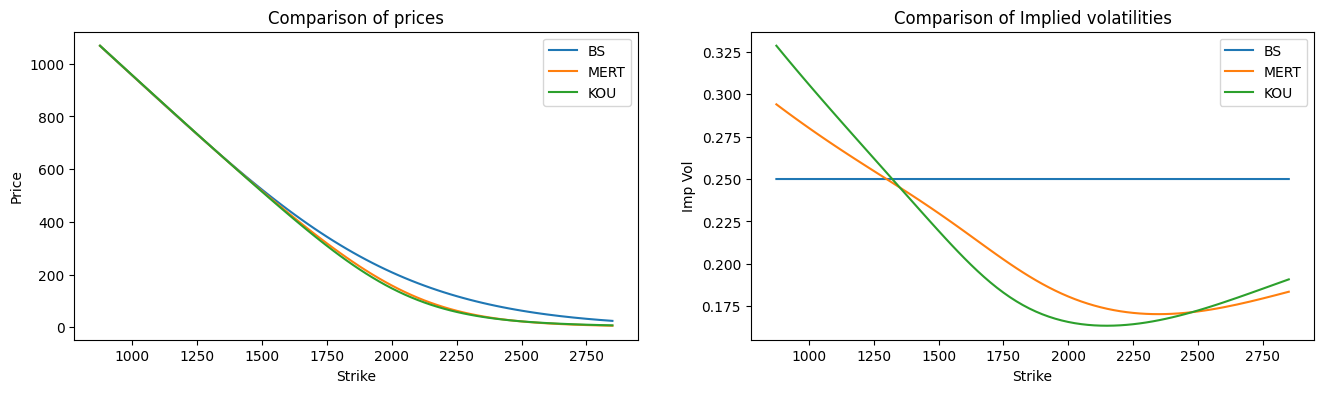

In [52]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(call_strikes, call_th_prices['BlackScholes'], label="BS"); ax1.plot(call_strikes, call_th_prices['Merton'], label="MERT")
ax1.plot(call_strikes, call_th_prices['Kou'], label="KOU")
ax1.set_title("Comparison of prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")

ax2.plot(call_strikes, imp_vol_call['BlackScholes'], label="BS"); ax2.plot(call_strikes, imp_vol_call['Merton'], label="MERT")
ax2.plot(call_strikes, imp_vol_call['Kou'], label="KOU")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")

ax1.legend(); ax2.legend(); plt.show()

## Calibration of Merton Jump Diffusion parameters
First we'll initialize a starting point in the array $x0 = [σ, λ, m, v]$
and we set bounds for the 4 parameters. Then we use the method
1. **curve_fit** of scipy.optimize. It uses the trf method when the parameters are bounded and the Levemberg-Marquadt method for unbounded parameters.

In [53]:
x0 = [0.15, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [0, 0, -10, 0.1], [np.inf, np.inf, 10, 5] )

def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)
#

- Method 1. curve_fit of scipy.optimize. It uses the trf method when the parameters are bounded and the Levemberg-Marquadt method for unbounded parameters.

In [54]:
res1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
mt = round(res1[0][2],2)
vt = round(res1[0][3],5)

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Jump Mean = ', mt)
print('> Calibrated Jump St. dev.  = ', vt)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] =  0.03952
> Calibrated Jump intensity [λ] =  0.11
> Calibrated Jump Mean =  0.12
> Calibrated Jump St. dev.  =  0.1


In [55]:
res1_2 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0)

sigt2 = round(res1_2[0][0],5)
lambdt2 = round(res1_2[0][1],2)
mt2 = round(res1_2[0][2],2)
vt2 = round(res1_2[0][3],5)

print('METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)')
print('> Calibrated Volatlity [σ] = ', sigt2)
print('> Calibrated Jump intensity [λ] = ', lambdt2)
print('> Calibrated Jump Mean = ', mt2)
print('> Calibrated Jump St. dev.  = ', vt2)

METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)
> Calibrated Volatlity [σ] =  0.00153
> Calibrated Jump intensity [λ] =  0.56
> Calibrated Jump Mean =  0.08
> Calibrated Jump St. dev.  =  0.0265


- Method 2. minimize(method=’SLSQP’)

In [56]:
x0 = [0.2, 0.5, -0.1, 1] # initial guess: [σ, λ, m, v]
bounds = [(0.01, 3), (0, np.inf), (-5, 5),  (0, 5)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, mean, std = x
    Mert = Merton_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, lambd=lamb, meanJ=mean, stdJ=std, exercise=exercise)
    return np.sum((Mert.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)

print(res2)
sigt, lambdt, mt, vt = res2.x

# Print the results
print('> METHOD 2: MINIMIZE (SLSQP)')
print('Calibrated Volatility [σ] =', round(sigt, 5))
print('Calibrated Jump Intensity [λ] =', round(lambdt, 2))
print('Calibrated Jump Mean [m] =', round(mt, 2))
print('Calibrated Jump St. dev. [v] =', round(vt, 2))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 8210682.413577191
       x: [ 2.000e-01  5.000e-01 -1.000e-01  1.000e+00]
     nit: 5
     jac: [ 1.310e+06  1.200e+07  1.012e+07  1.713e+07]
    nfev: 5
    njev: 1
> METHOD 2: MINIMIZE (SLSQP)
Calibrated Volatility [σ] = 0.2
Calibrated Jump Intensity [λ] = 0.5
Calibrated Jump Mean [m] = -0.1
Calibrated Jump St. dev. [v] = 1.0


## Calibration of Kou Jump Diffusion parameters